In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
import numpy as np
import os
import os.path
import pytest
import os.path as op
import sys
import matplotlib.pyplot as plt
import scipy
import glob
from pathlib import Path

sys.path.insert(0,str(Path("~/projects/imtools").expanduser()))

import imtools.trainer3d
import imtools.datasets
import imtools.ml
import io3d
import sed3
from loguru import logger
# logger.disable("io3d")
logger.remove()
logger.add(sys.stderr, level='INFO')

2

# Training

In [21]:
# Define feature function
def externfv(data3d, voxelsize_mm):        # scale
    f0 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=3).reshape(-1, 1)
    f1 = scipy.ndimage.filters.gaussian_filter(data3d, sigma=1).reshape(-1, 1) - f0
    fv = np.concatenate([
        f0, f1
    ], 1)
    return fv

In [22]:

ol = imtools.trainer3d.Trainer3D()
# select feature function
ol.feature_function = externfv
# select classifier
ol.cl = imtools.ml.gmmcl.GMMCl(n_components=3)

for i in range(1, 5):
    datap = io3d.datasets.read_dataset("3Dircadb1", 'data3d', i)
    datap_liver = io3d.datasets.read_dataset("3Dircadb1", 'liver', i)
    ol.add_train_data(datap["data3d"], (datap_liver["data3d"] > 0).astype(np.uint8), voxelsize_mm=datap["voxelsize_mm"])

ol.fit()

# Testing

In [23]:
# one = list(imtools.datasets.sliver_reader("*000.mhd", read_seg=True))[0]
# numeric_label, vs_mm, oname, orig_data, rname, ref_data = one
i = 3
datap = io3d.datasets.read_dataset("3Dircadb1", 'data3d', i)
fit = ol.predict(datap["data3d"], voxelsize_mm=datap["voxelsize_mm"])



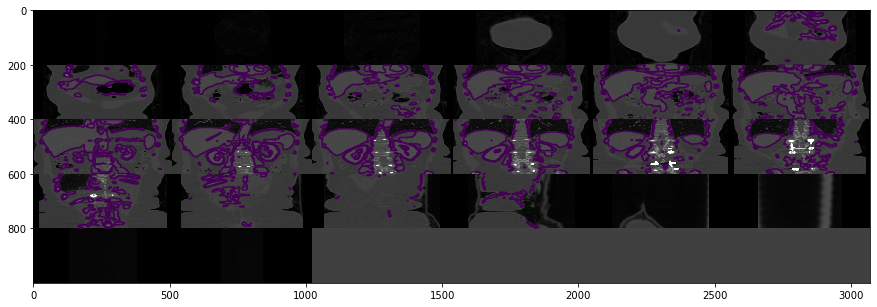

In [24]:
#  visualization
plt.figure(figsize=(15, 10))
sed3.show_slices(datap["data3d"], fit, slice_step=20, axis=1, flipV=False)